# Cartpole: Q Learning

We've done some work with cartpole using a deep neural network.  Let's compare it performance against a simpler tabular method.

In [4]:
import numpy as np
import gym
from importlib import reload
import random

import cartpole_lab.agent
import cartpole_lab.deeprico
import cartpole_lab.approximator
import cartpole_lab.charts
reload(cartpole_lab.agent)
reload(cartpole_lab.deeprico)
reload(cartpole_lab.approximator)
reload(cartpole_lab.charts)

from cartpole_lab.deeprico import deep_rico
from cartpole_lab.charts import histogram, plot_fn
from cartpole_lab.functions import sigmoid


Using TensorFlow backend.


In [5]:
env = gym.make('CartPole-v1')
observation = env.reset()

## Comparison: Deep Rico
For comparison, let's grab an instance of the DeepRico, the Deep Q Learning agent.

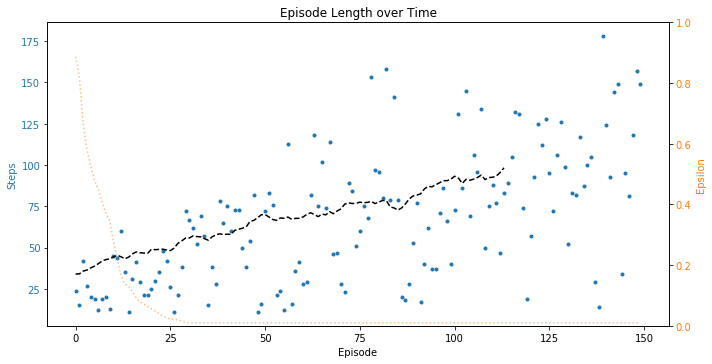

Max length=178.000000 avg=66.640000


In [3]:
deep_q_learn = deep_rico(env)
deep_q_learn.train(150)

In [ ]:
deep_q_learn.train(50)

In [ ]:
def play_visually(agent):
    for i in range(15):
        agent.run_episode(render=True)
play_visually(deep_q_learn)

In [ ]:
env.close()

In [ ]:
deep_q_learn.train(150)

## Save model
[How to save Keras models](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

In [ ]:
x = deep_q_learn.policy.model.model.save(r'models\cartpole-deep-q1.h5')
x

## Determine Bin Ranges

In [4]:
len(deep_q_learn.policy.snapshots)

9996

In [5]:
def histogram_state(index, agent):
    x = [state[index] for (state, action, reward, state_next, done) in agent.policy.snapshots]
    histogram(x, title='State %d' % index)

def histogram_state_space(agent):
    """Call this on an agent with some experience to see the ranges of the states it has experienced."""
    state_feature_count = len(agent.policy.snapshots[0][0])
    for i in range(state_feature_count):
        histogram_state(i, agent)

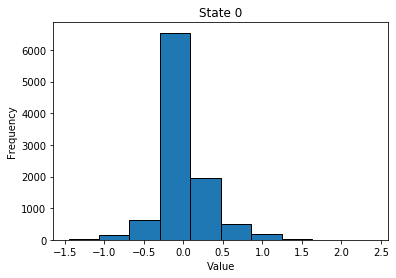

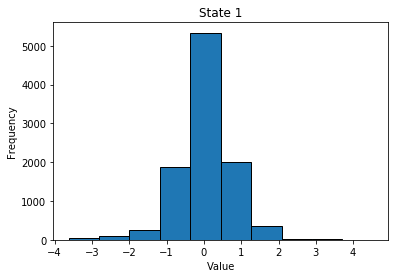

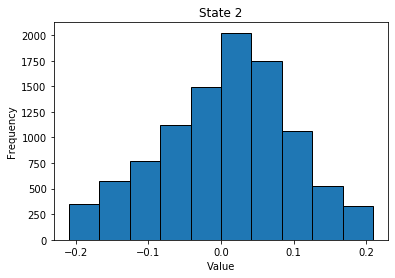

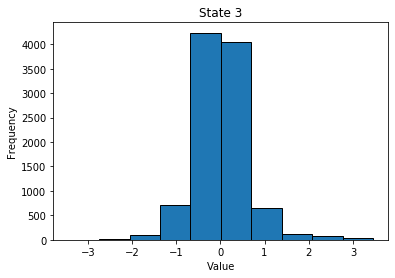

In [6]:
histogram_state_space(deep_q_learn)

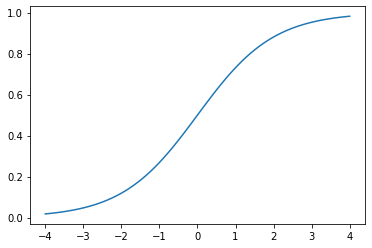

In [7]:
plot_fn(sigmoid, -4, 4)

Looks like sigmoid fits the ranges we'll be seeing in all cases pretty well.  We will try mapping the inputs through a sigmoid to give us more resolution between features in the areas that we commonly see.

## Discretizer

We need something that takes in an observation and makes a discrete state.  This discrete state will be used as the dictionary key for our state information table.  Note that only immutable types can be used as dictionary keys, which means tuples are fine but lists are not.

We'll use [numpy.digitize](https://docs.scipy.org/doc/numpy/reference/generated/numpy.digitize.html) to pack things into bins.

In [8]:
bins = np.array([-4, -3, -2, -1, 0, 1, 2, 3])
x = np.array([-3.5, -2.9, -1.5])
np.digitize(x, bins)

array([1, 2, 3], dtype=int64)

In [9]:
x = np.array([-5, -4.5, -4.0, -3.9, 700])
np.digitize(x, bins)

array([0, 0, 1, 1, 8], dtype=int64)

In [10]:
from cartpole_lab.discretizer import Discretizer

In [11]:
d = Discretizer([(-4, 4), (-4, 4), (-1, 1), (-4, 4)])
print(d.bins)

[array([-4.00000000e+00, -3.20000000e+00, -2.40000000e+00, -1.60000000e+00,
       -8.00000000e-01, -2.22044605e-16,  8.00000000e-01,  1.60000000e+00,
        2.40000000e+00,  3.20000000e+00]), array([-4.00000000e+00, -3.20000000e+00, -2.40000000e+00, -1.60000000e+00,
       -8.00000000e-01, -2.22044605e-16,  8.00000000e-01,  1.60000000e+00,
        2.40000000e+00,  3.20000000e+00]), array([-1.00000000e+00, -8.00000000e-01, -6.00000000e-01, -4.00000000e-01,
       -2.00000000e-01, -5.55111512e-17,  2.00000000e-01,  4.00000000e-01,
        6.00000000e-01,  8.00000000e-01]), array([-4.00000000e+00, -3.20000000e+00, -2.40000000e+00, -1.60000000e+00,
       -8.00000000e-01, -2.22044605e-16,  8.00000000e-01,  1.60000000e+00,
        2.40000000e+00,  3.20000000e+00])]


In [12]:
obs = env.reset()
print(obs)
d.get(obs)

[-0.00773492 -0.03176692 -0.01555334 -0.00883477]


(5, 5, 5, 5)

In [13]:
[(state, d.get(state)) for (state, action, reward, state_next, done) in random.sample(deep_q_learn.policy.snapshots,5)]

[(array([1.35234177, 1.28652697, 0.19780901, 0.42245127]), (7, 7, 6, 6)),
 (array([-0.26551829,  0.01543392,  0.05904178, -0.41453785]), (5, 6, 6, 5)),
 (array([ 0.21358686,  0.96798227,  0.06591308, -0.50573944]), (6, 7, 6, 5)),
 (array([-0.4136418 , -0.67407663, -0.13668821, -0.22670672]), (5, 5, 5, 5)),
 (array([ 0.01406445, -0.35478818,  0.01900916,  0.50586091]), (6, 5, 6, 6))]

## SARSA Agent

For each state we want to know expected future rewards. At each step, we will update as follows.  (See Sutton and Barto p130)

$$ Q(S_t, A_t) = Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \right] $$

 * alpha: learning rate 0-1
 * gamma: future reward discount rate 0-1


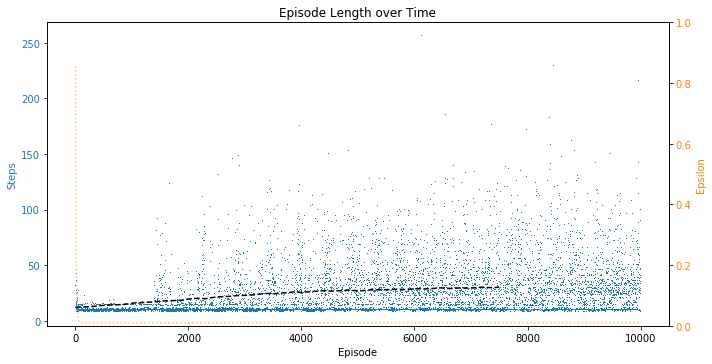

Max length=256.000000 avg=22.897700


In [14]:
import cartpole_lab.qlearn
import cartpole_lab.agent
import cartpole_lab.charts
reload(cartpole_lab.qlearn)
reload(cartpole_lab.agent)
reload(cartpole_lab.charts)

qlearn = cartpole_lab.qlearn.q_learning(env)
qlearn.train(10000)

In [ ]:
len(qlearn.policy.qvalues)

In [16]:
qlearn.policy.peek()

array([45.7210335 , 45.93158936])

In [ ]:
for i in range(10):
    qlearn.run_episode()

## Q Learning Hindsight Agent
The strategy here is to store the total rewards from the episode in each state/action pair.  The idea is: in a given situation, here's the total rewards we got when we took this action.

In [ ]:
import gym
from importlib import reload
import cartpole_lab.qhindsight
import cartpole_lab.agent
import cartpole_lab.charts
reload(cartpole_lab.qhindsight)
reload(cartpole_lab.agent)
reload(cartpole_lab.charts)

env = gym.make('CartPole-v1')
qhindsight = cartpole_lab.qhindsight.q_hindsight_agent(env)
qhindsight.train(1000000)

In [3]:
qhindsight.policy.qvalues[(6, 5, 6, 7)]

array([9.30826285, 1.480962  ])

In [14]:
qhindsight.policy.peek()

array([8.7420572, 4.6162208])

In [15]:
qhindsight.policy.qvalues

defaultdict(<function cartpole_lab.qhindsight.QHindsightPolicy.__init__.<locals>.<lambda>()>,
            {(5, 5, 5, 6): array([10.04186129,  2.14068838]),
             (5, 6, 5, 5): array([2.6815303 , 9.01898484]),
             (6, 6, 5, 5): array([14.43373952, 14.04634446]),
             (6, 5, 5, 6): array([10.6204141 ,  2.12879348]),
             (6, 6, 5, 4): array([3.57319493, 9.44282007]),
             (5, 6, 6, 6): array([0.43972988, 0.40818555]),
             (5, 6, 6, 5): array([1.10849638, 9.97132376]),
             (6, 6, 4, 4): array([0.   , 0.024]),
             (5, 5, 6, 6): array([8.7420572, 4.6162208]),
             (6, 7, 5, 4): array([3.0511806 , 9.41673537]),
             (5, 4, 6, 7): array([9.44080442, 5.0775832 ]),
             (5, 6, 5, 6): array([0.23657461, 0.25445629]),
             (5, 5, 6, 7): array([9.09498635, 5.77578032]),
             (5, 4, 6, 8): array([9.67386629, 5.7045542 ]),
             (6, 7, 4, 3): array([0.52375791, 0.96942776]),
            